# How Good Might Teddy Ballgame Have Been?

In [1]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("darkgrid")
from itertools import accumulate
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# http://www.seanlahman.com/baseball-archive/statistics/
# inspired by https://www.reddit.com/r/redsox/comments/kdjeih/5_am_ted_williams_rant/

In [2]:
people = pd.read_csv("/Users/joshherzberg/Downloads/baseballdatabank-master/core/People.csv")

people = people.dropna(subset=["birthMonth", "birthDay", "birthYear", "debut"], how="any")

people["birthday"] = people.apply(lambda row: datetime.date(int(row["birthYear"]), int(row["birthMonth"]), int(row["birthDay"])), axis=1)

batting = pd.read_csv("/Users/joshherzberg/Downloads/baseballdatabank-master/core/Batting.csv")

batting = pd.merge(batting.drop_duplicates(subset=["playerID", "yearID"], keep="first")[['playerID', 'yearID', 'stint', 'teamID', 'lgID']],
     batting.groupby(["playerID", "yearID"]).sum().reset_index()[['playerID', 'yearID', 'G', 'AB', 'R', 'H',
           '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
           'SF', 'GIDP']],)

df = batting.merge(people, on="playerID", how="inner")

In [3]:
df["age"] = df.apply(lambda row: int((datetime.datetime(int(row["yearID"]), 4, 1) - 
                                      datetime.datetime.strptime(row["debut"], "%Y-%m-%d")).days), axis=1)

df["age"] = df["age"].clip(lower=0)

df["AVG"] = df["H"] / df["AB"]
df["1B"] = df["H"] - (df["2B"] + df["3B"] + df["HR"])
df["SLUG"] = (df["1B"] + 2*df["2B"] + 3*df["3B"] + 4*df["HR"]) / df["AB"]
df["OBP"] = (df["H"] + df["BB"] + df["HBP"]) / (df["AB"] + df["BB"] + df["HBP"] + df["SH"] + df["SF"])

derived_cols = ["AVG", "1B", "SLUG", "OBP"]

In [4]:
big_papi = (df["nameLast"] == "Ortiz") & (df["nameGiven"].str.contains("David"))

ted_williams = (df["nameLast"] == "Williams") & (df["nameGiven"].str.contains("Theodore"))

yaz = (df["nameLast"] == "Yastrzemski") & (df["nameGiven"].str.contains("Carl"))

boggs = (df["nameLast"] == "Boggs") & (df["nameGiven"].str.contains("Wade"))


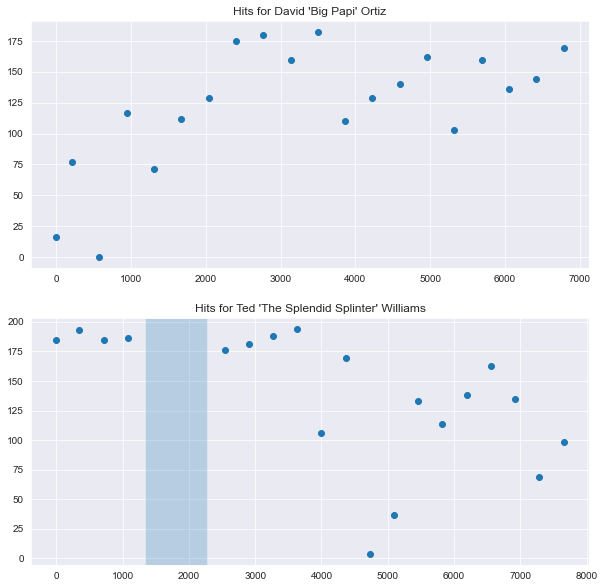

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

ted_age_reindexed = [df[ted_williams]["age"].iloc[0]] + [df[ted_williams]["age"].iloc[1] + 365.25*i for i in range(len(df[ted_williams]["age"])+2)]

ax[0].scatter(df[big_papi]["age"], df[big_papi]["H"])
ax[1].scatter(df[ted_williams]["age"], df[ted_williams]["H"])
ax[1].axvspan(ted_age_reindexed[4]-100, ted_age_reindexed[6]+100, alpha=.25)
ax[0].set_title("Hits for David 'Big Papi' Ortiz")
ax[1].set_title("Hits for Ted 'The Splendid Splinter' Williams")
plt.show()

Text(0.5, 1.0, "Boston Red Sox Hitters' Cumulative Hits")

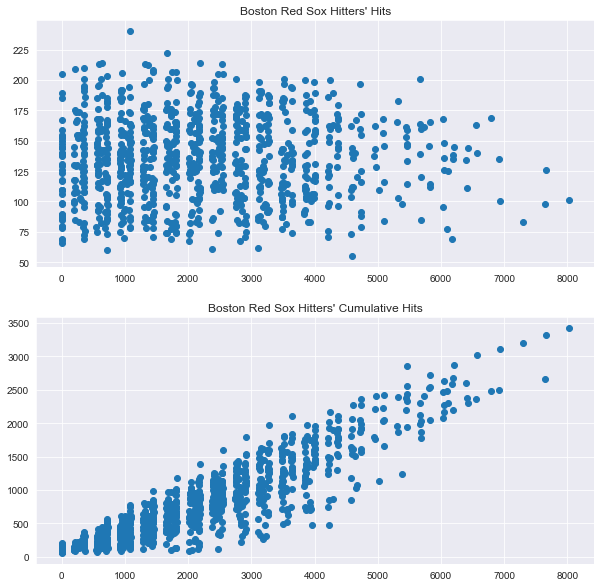

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))

hitters = (df["AB"] > 300)
bos_hitters = (df["teamID"] == "BOS") & hitters

ax[0].scatter(x=df[bos_hitters]["age"],
              y=df[bos_hitters]["H"])
ax[0].set_title("Boston Red Sox Hitters' Hits")

bat_cols = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',
       'SF', 'GIDP',]
        
df[["c" + col for col in bat_cols]] = df.groupby("playerID").cumsum()[bat_cols]

ax[1].scatter(x=df[bos_hitters]["age"],
            y=df[bos_hitters]["cH"])
ax[1].set_title("Boston Red Sox Hitters' Cumulative Hits")

Text(0.5, 1.0, "Red Sox Greats' Hits")

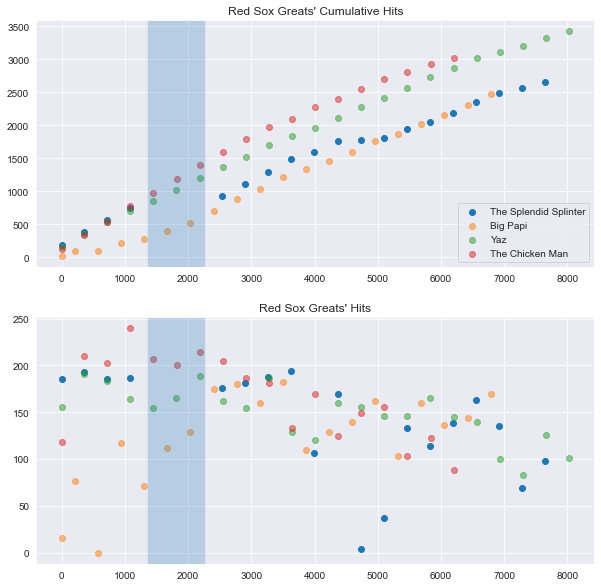

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].scatter(x=df[ted_williams]["age"], y=df[ted_williams]["cH"])
ax[0].scatter(x=df[big_papi]["age"], y=df[big_papi]["cH"], alpha=.5)
ax[0].scatter(x=df[yaz]["age"], y=df[yaz]["cH"], alpha=.5)
ax[0].scatter(x=df[boggs]["age"], y=df[boggs]["cH"], alpha=.5)
ax[0].legend(["The Splendid Splinter", 
            "Big Papi", 
            "Yaz", 
            "The Chicken Man"])
ax[0].axvspan(ted_age_reindexed[4]-100, ted_age_reindexed[6]+100, alpha=.25)
ax[0].set_title("Red Sox Greats' Cumulative Hits")

ax[1].scatter(x=df[ted_williams]["age"], y=df[ted_williams]["H"])
ax[1].scatter(x=df[big_papi]["age"], y=df[big_papi]["H"], alpha=.5)
ax[1].scatter(x=df[yaz]["age"], y=df[yaz]["H"], alpha=.5)
ax[1].scatter(x=df[boggs]["age"], y=df[boggs]["H"], alpha=.5)
ax[1].axvspan(ted_age_reindexed[4]-100, ted_age_reindexed[6]+100, alpha=.25)
ax[1].set_title("Red Sox Greats' Hits")

# KNN

In [8]:
# reindex_career(df[ted_williams])

In [9]:
def reindex_career(career):
    ix = range(career["yearID"].min(), career["yearID"].max()+1)
    df_reset = career.set_index("yearID", drop=True).reindex(range(
                                                            career["yearID"].min(), 
                                                            career["yearID"].min() + 36
                                                        )).reset_index()
    df_reset["playerID"] = career["playerID"].values[0]
    return df_reset

knn_cols = ['AVG', 'SLUG', 'OBP', 'H', 'AB', '2B']
# consider scaling
reindex_career(df[ted_williams]).iloc[3][knn_cols]

AVG     0.356322
SLUG     0.64751
OBP     0.499255
H            186
AB           522
2B            34
Name: 3, dtype: object

In [10]:
df["knncol_linalgnorm"] = df.apply(lambda row: np.linalg.norm(row[knn_cols] - df[ted_williams].iloc[3][knn_cols]), axis=1)

In [11]:
knn_5 = df[df["playerID"] != "willite01"].sort_values(by="knncol_linalgnorm", ascending=True).head(5)
knn_5[["nameGiven", "nameLast", "yearID"] + bat_cols + ["AVG", "SLUG", "OBP"]]

,nameGiven,nameLast,yearID,G,AB,R,H,2B,3B,HR,...,BB,SO,IBB,HBP,SH,SF,GIDP,AVG,SLUG,OBP
10958,Tristram E.,Speaker,1913,141,520,94,189,35,22,3,...,65,22.0,0.0,7.0,16.0,0.0,0.0,0.363462,0.532692,0.429276
4952,George Stacey,Davis,1897,131,521,112,184,31,10,10,...,43,23.0,0.0,7.0,5.0,0.0,0.0,0.353167,0.508637,0.406250
21718,Melvin Thomas,Ott,1930,148,521,122,182,34,5,25,...,103,35.0,0.0,2.0,20.0,0.0,0.0,0.349328,0.577735,0.444272
17485,Royce Middlebrook,Youngs,1924,133,526,112,187,33,12,10,...,77,31.0,0.0,3.0,6.0,0.0,0.0,0.355513,0.520913,0.436275
18314,Bibb August,Falk,1924,138,526,77,185,37,8,6,...,47,21.0,0.0,1.0,20.0,0.0,0.0,0.351711,0.486692,0.392256


In [12]:
display(df.loc[knn_5.index + 3][["nameGiven", "nameLast", "yearID"] + bat_cols])

,nameGiven,nameLast,yearID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
10961,Tristram E.,Speaker,1916,151,546,102,211,41,8,2,79.0,35.0,27.0,82,20.0,0.0,4.0,15.0,0.0,0.0
4955,George Stacey,Davis,1900,114,426,69,136,20,4,3,61.0,29.0,0.0,35,23.0,0.0,4.0,7.0,0.0,0.0
21721,Melvin Thomas,Ott,1933,152,580,98,164,36,1,23,103.0,1.0,0.0,75,48.0,0.0,2.0,4.0,0.0,10.0
17488,William Capers,Bass,1918,2,1,1,1,0,0,0,0.0,1.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0
18317,Bibb August,Falk,1927,145,535,76,175,35,6,9,83.0,5.0,7.0,52,19.0,0.0,4.0,22.0,0.0,0.0


In [13]:
ted_hits_reil = list(reindex_career(df[ted_williams])["H"])
ted_hits_reil[4] = df.loc[knn_5.index + 1]["H"].mean()
ted_hits_reil[5] = df.loc[knn_5.index + 2]["H"].mean()
ted_hits_reil[6] = df.loc[knn_5.index + 3]["H"].mean()

In [14]:
ted_hits_reil[4:7]

[160.0, 161.2, 137.4]

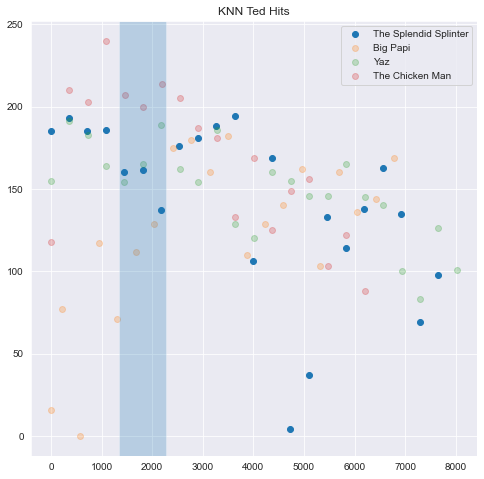

In [15]:
ted_knn_hits = [i for i in ted_hits_reil if not np.isnan(i)]
plt.figure(figsize=(8, 8))
plt.scatter(x=ted_age_reindexed, y=ted_knn_hits)
plt.scatter(x=df[big_papi]["age"], y=df[big_papi]["H"], alpha=.25)
plt.scatter(x=df[yaz]["age"], y=df[yaz]["H"], alpha=.25)
plt.scatter(x=df[boggs]["age"], y=df[boggs]["H"], alpha=.25)
plt.legend(["The Splendid Splinter", 
            "Big Papi", 
            "Yaz", 
            "The Chicken Man"])
plt.title("KNN Ted Hits")
plt.axvspan(ted_age_reindexed[4]-100, ted_age_reindexed[6]+100, alpha=.25)

# Lin Reg

In [16]:
full_season = [28436, 28437, 28438, 28439, 28440, 28441, 28442, 28443, 28444,
            28445, 28448, 28449, 28450, 28451, 28452, 28453,
            28454]
reg = LinearRegression().fit(np.array(df[ted_williams].loc[full_season]["age"]).reshape(-1, 1), 
                             np.array(df[ted_williams].loc[full_season]["H"]).reshape(-1, 1))
# holdout for different methods

In [17]:
reg.score(np.array(df[ted_williams]["age"]).reshape(-1, 1),
          np.array(df[ted_williams]["H"]).reshape(-1, 1))

0.2797498843962025

In [18]:
lin_reg_preds = reg.predict(np.array(ted_age_reindexed).reshape(-1, 1)[4:7]).reshape(3,)
lin_reg_preds

array([184.53596483, 180.20564142, 175.87531801])

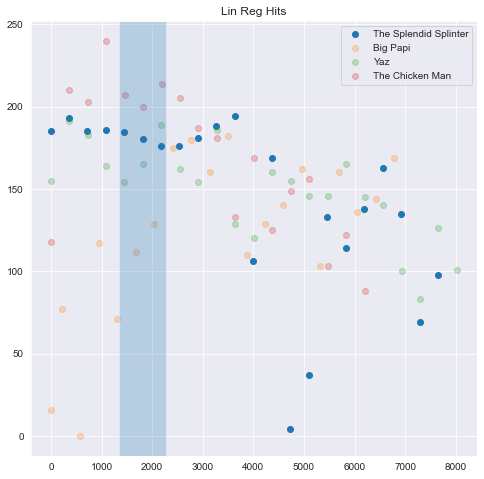

In [19]:
ted_hits_reil = list(reindex_career(df[ted_williams])["H"])
ted_hits_reil[4:7] =  lin_reg_preds

ted_knn_hits = [i for i in ted_hits_reil if not np.isnan(i)]
plt.figure(figsize=(8, 8))
plt.scatter(x=ted_age_reindexed, y=ted_knn_hits)
plt.scatter(x=df[big_papi]["age"], y=df[big_papi]["H"], alpha=.25)
plt.scatter(x=df[yaz]["age"], y=df[yaz]["H"], alpha=.25)
plt.scatter(x=df[boggs]["age"], y=df[boggs]["H"], alpha=.25)
plt.legend(["The Splendid Splinter", 
            "Big Papi", 
            "Yaz",
            "The Chicken Man"])
plt.title("Lin Reg Hits")
plt.axvspan(ted_age_reindexed[4]-100, ted_age_reindexed[6]+100, alpha=.25)

# Simple Mean

In [20]:
ted_simple_mean_hits = [i if not np.isnan(i) else df[ted_williams]["H"].iloc[:8].mean() for i in reindex_career(df[ted_williams])["H"][:22]]

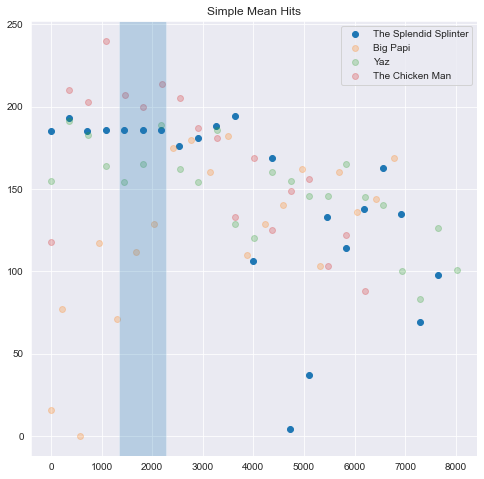

In [21]:
plt.figure(figsize=(8, 8))
plt.scatter(x=ted_age_reindexed, y=ted_simple_mean_hits)
plt.scatter(x=df[big_papi]["age"], y=df[big_papi]["H"], alpha=.25)
plt.scatter(x=df[yaz]["age"], y=df[yaz]["H"], alpha=.25)
plt.scatter(x=df[boggs]["age"], y=df[boggs]["H"], alpha=.25)
plt.legend(["The Splendid Splinter", 
            "Big Papi", 
            "Yaz", 
            "The Chicken Man"])
plt.title("Simple Mean Hits")
plt.axvspan(ted_age_reindexed[4]-100, ted_age_reindexed[6]+100, alpha=.25)

# NN

In [22]:
nn_cols = ['G', 'AB', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'IBB', 'HBP', 'SH',\
           'SF', 'GIDP', 'weight', 'height', 'age', 'AVG', '1B', 'SLUG', 'OBP']

def check_career_is_continuous(career_year_list):
    return list(range(career_year_list[0], career_year_list[-1] + 1)) == career_year_list

X = []
Y= [] 
for playerID in df["playerID"].unique():
    career = df[df["playerID"] == playerID]
    if len(career) > 3 and check_career_is_continuous(list(career["yearID"])):
        x = career[nn_cols][:-3].values.tolist()
        y = [[career.loc[i+1]["H"], career.loc[i+2]["H"], career.loc[i+3]["H"]] for i in career.index[:-3]]
        if not np.isnan(x).any() and not np.isnan(y).any():
            X.extend(x)
            Y.extend(y)


In [23]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(Y),
                                                    random_state=1)
regr = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)

In [24]:
nn_preds = regr.predict([np.array(df[ted_williams].loc[28443][nn_cols])])
display(nn_preds)

display(regr.score(X_test, y_test))

array([[175.36183938, 180.76337101, 157.53678702]])

0.5640168103708031

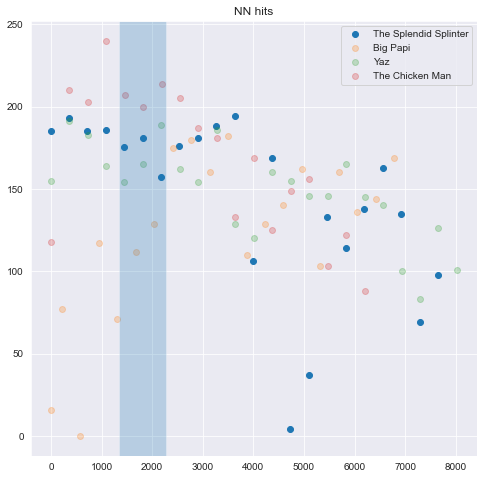

In [25]:
ted_hits_reil = list(reindex_career(df[ted_williams])["H"])
ted_hits_reil[4:7] = nn_preds[0]


ted_knn_hits = [i for i in ted_hits_reil if not np.isnan(i)]
plt.figure(figsize=(8, 8))
plt.scatter(x=ted_age_reindexed, y=ted_knn_hits)
plt.scatter(x=df[big_papi]["age"], y=df[big_papi]["H"], alpha=.25)
plt.scatter(x=df[yaz]["age"], y=df[yaz]["H"], alpha=.25)
plt.scatter(x=df[boggs]["age"], y=df[boggs]["H"], alpha=.25)
plt.legend(["The Splendid Splinter", 
            "Big Papi", 
            "Yaz",
            "The Chicken Man"])
plt.title("NN hits")
plt.axvspan(ted_age_reindexed[4]-100, ted_age_reindexed[6]+100, alpha=.25)

# Pandas Methods

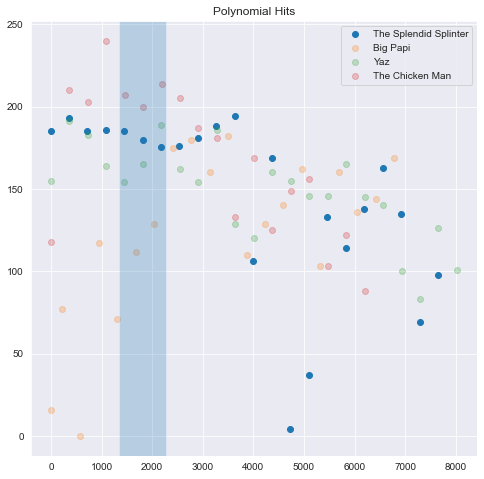

In [26]:
plt.figure(figsize=(8, 8))
plt.scatter(x=ted_age_reindexed, y=reindex_career(df[ted_williams])["H"][:22].interpolate('polynomial', order=2))
plt.scatter(x=df[big_papi]["age"], y=df[big_papi]["H"], alpha=.25)
plt.scatter(x=df[yaz]["age"], y=df[yaz]["H"], alpha=.25)
plt.scatter(x=df[boggs]["age"], y=df[boggs]["H"], alpha=.25)
plt.legend(["The Splendid Splinter", 
            "Big Papi", 
            "Yaz",
            "The Chicken Man"])
plt.title("Polynomial Hits")
plt.axvspan(ted_age_reindexed[4]-100, ted_age_reindexed[6]+100, alpha=.25)